In [3]:
import gym
import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions import Categorical
import random
import numpy as np
import torch as T

In [4]:
class RND(nn.Module):
    def __init__(self,in_features):
        super(RND,self).__init__()
        self.fc1 = nn.Linear(*in_dims,out_features=256)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(256,64)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(64,1)
        
    def forward(self,observation):
        state = T.FloatTensor(observation)
        x = self.relu1(self.fc1(state))
        x = self.relu2(self.fc2(x))
        x = self.fc3(x)
        return x

In [5]:
# feature = RND(in_dims)
# predictor = RND(in_dims)
# objective = nn.MSELoss(reduction='mean')
# intrinsic_optim = optim.RMSprop(params=predictor.parameters(),lr=0.001)

# state = env.reset()

# feat_out = feature(state)
# pred_out = predictor(state)
# curiosity_reward = T.abs(feat_out-pred_out)

# loss = objective(pred_out,feat_out)

# intrinsic_optim.zero_grad()
# loss.backward()
# intrinsic_optim.step()

In [6]:
class Qnet(nn.Module):
    def __init__(self,in_dims,n_actions,alpha):
        super(Qnet,self).__init__()
        self.in_dims = in_dims
        self.n_actions = n_actions
        self.fc1 = nn.Linear(*self.in_dims,256)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(256,256)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(256,self.n_actions)
        self.loss = nn.MSELoss() ###
        self.optimizer = optim.RMSprop(params=self.parameters(),lr=alpha)
        
    def forward(self,observation):
        state = T.FloatTensor(observation)
        x = self.relu1(self.fc1(state))
        x = self.relu2(self.fc2(x))
        actions = self.fc3(x)
        return actions

In [7]:
class Agent(object):
    def __init__(self,in_dims,n_actions,alpha,epsilon,gamma,batch_size,reply_mem_size,epsilon_min=0.01,epsilon_decrease=0.996):
        self.in_dims = in_dims
        self.action_space = [i for i in range(n_actions)]
        self.n_actions = n_actions
        self.alpha = alpha
        self.gamma = gamma
        self.batch_size = batch_size
        self.reply_mem_size = reply_mem_size
        self.mem_cntr = 0
        
        self.epsilon = epsilon
        self.epsilon_min = epsilon_min
        self.epsilon_decrease = epsilon_decrease
        
        # define memories
        self.state_mem = np.zeros((self.reply_mem_size,*self.in_dims))
        self.action_mem = np.zeros((self.reply_mem_size,self.n_actions))
        self.reward_mem = np.zeros((self.reply_mem_size))
        self.next_state_mem = np.zeros((self.reply_mem_size,*self.in_dims))
        self.is_done_mem = np.zeros((self.reply_mem_size))
        
        # define brain
        self.brain = Qnet(self.in_dims,self.n_actions,self.alpha)
        
        
    def store_experiance(self,state,action,reward,next_state,is_done):
        index = self.mem_cntr % self.reply_mem_size
        
        self.state_mem[index] = state
        actions = np.zeros(self.n_actions)
        actions[action] = 1.0
        self.action_mem[index] = actions
        self.reward_mem[index] = reward
        self.next_state_mem[index] = next_state
        self.is_done_mem[index] = 1 - is_done
        self.mem_cntr += 1
        
    
    def act(self,observation):
        net_act = self.brain.forward(observation)
        if  np.random.random() > self.epsilon:
            action = T.argmax(net_act).item()
        else:
            action = np.random.choice(self.action_space)
        return action
            
            
    def learn(self):
        if self.mem_cntr > self.batch_size:
            self.brain.optimizer.zero_grad()
            
            max_mem = self.mem_cntr if self.mem_cntr < self.reply_mem_size else self.reply_mem_size
            
            batch = np.random.choice(max_mem,self.batch_size)
            
            state_batch = self.state_mem[batch]
            action_batch = self.action_mem[batch]
            action_values = np.array(self.action_space)
            action_indices = np.dot(action_batch, action_values)
            reward_batch = T.Tensor(self.reward_mem[batch])
            next_state_batch = self.next_state_mem[batch]
            is_done_batch = T.Tensor(self.is_done_mem[batch])
            
            self.q_eval = self.brain.forward(state_batch)
            self.q_target = self.q_eval.clone()
            self.q_next = self.brain.forward(next_state_batch)
            
            batch_index = np.arange(self.batch_size)
            
            self.q_target[batch_index,action_indices] = reward_batch + self.gamma * T.max(self.q_next,dim=1)[0] * is_done_batch
            
            self.epsilon = self.epsilon * self.epsilon_decrease if self.epsilon > self.epsilon_min else self.epsilon_min
            
            loss = self.brain.loss(self.q_target,self.q_eval)
            loss.backward()
            self.brain.optimizer.step()
            
            

In [8]:
env = gym.make("Acrobot-v1")

state_reset = env.reset()

in_dims = state_reset.shape
n_actions = env.action_space.n
print(in_dims,n_actions)

(6,) 3


In [9]:
alpha = 0.001
epsilon = 1.0
gamma = 0.9
batch_size = 248
reply_mem_size = 100000
driver = Agent(in_dims,n_actions,alpha,epsilon,gamma,batch_size,reply_mem_size)

In [10]:
n_episodes = 1000

In [11]:
scores = []
eps_history = []
feature = RND(in_dims)
predictor = RND(in_dims)
objective = nn.MSELoss(reduction='mean')
intrinsic_optim = optim.RMSprop(params=predictor.parameters(),lr=0.00001)
for i in range(n_episodes):
#     print("---------------------------- ","episode",i," --------------------------")
    done = False
    observation = env.reset()
    score = 0
    while not done:
        action = driver.act(observation)
        observation_, reward, done, info = env.step(action)
#         env.render()

#         # Curiosity Implemented Start
#         feat_out = feature(torch.FloatTensor(observation_))
#         pred_out = predictor(torch.FloatTensor(observation_))
#         curiosity_reward = T.abs(feat_out-pred_out)
#         loss = objective(pred_out,feat_out)
#         intrinsic_optim.zero_grad()
#         loss.backward()
#         intrinsic_optim.step()
#         reward += loss.item()*10
#         # Curiosity Implemented End
        
        
        score += reward
        driver.store_experiance(observation, action, reward, observation_,done)
        observation = observation_
#     if i % 10 == 0:
    driver.learn()
#     env.close()
    scores.append(score)
    eps_history.append(driver.epsilon)
    if i % 10 == 0:
        print("episode :",i,"\n","avg_score :",np.mean(scores[max(0, i-10):(i+1)]),"\n","epsilon :",driver.epsilon)
#         print("episode :",i,"\n","avg_score :",scores[i],"\n","epsilon :",driver.epsilon)

episode : 0 
 avg_score : -500.0 
 epsilon : 0.996
episode : 10 
 avg_score : -500.0 
 epsilon : 0.9568695240087989
episode : 20 
 avg_score : -500.0 
 epsilon : 0.9192763915429975
episode : 30 
 avg_score : -500.0 
 epsilon : 0.8831602040243718
episode : 40 
 avg_score : -500.0 
 epsilon : 0.8484629357914802
episode : 50 
 avg_score : -500.0 
 epsilon : 0.8151288408733952
episode : 60 
 avg_score : -500.0 
 epsilon : 0.7831043634260739
episode : 70 
 avg_score : -470.8181818181818 
 epsilon : 0.7523380516874708
episode : 80 
 avg_score : -480.72727272727275 
 epsilon : 0.72278047531315
episode : 90 
 avg_score : -500.0 
 epsilon : 0.6943841459595858
episode : 100 
 avg_score : -500.0 
 epsilon : 0.6671034409875553
episode : 110 
 avg_score : -500.0 
 epsilon : 0.640894530163046
episode : 120 
 avg_score : -497.09090909090907 
 epsilon : 0.6157153052379084
episode : 130 
 avg_score : -494.09090909090907 
 epsilon : 0.5915253122971182
episode : 140 
 avg_score : -500.0 
 epsilon : 0.568

KeyboardInterrupt: 

In [ ]:
driver.mem_cntr

In [17]:
import matplotlib.pyplot as plt

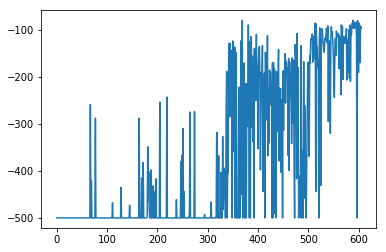

In [18]:
plt.plot(scores)

In [110]:
env.close()

In [13]:
import time

In [15]:
for i in range(5):
    done = False
    observation = env.reset()
    driver.epsilon = 0.01
#     driver.epsilon = 1.0
    reward_check = 0
    while not done:
        action = driver.act(observation)
        observation_, reward, done, info = env.step(action)
        reward_check += reward
        env.render()
        observation = observation_
    
    env.close()
    print(reward_check)
    time.sleep(4)

-111.0
-113.0
-96.0
-96.0
-104.0


In [78]:
# torch.save(driver,'lunar_lander_3780ep_0.001_0.1_0.9_1024_100000_shaky_wrkround')

C:\ProgramData\Anaconda3\lib\site-packages\torch\serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Qnet. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
C:\ProgramData\Anaconda3\lib\site-packages\torch\serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Linear. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
C:\ProgramData\Anaconda3\lib\site-packages\torch\serialization.py:292: UserWarning: Couldn't retrieve source code for container of type ReLU. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
C:\ProgramData\Anaconda3\lib\site-packages\torch\serialization.py:292: UserWarning: Couldn't retrieve source code for container of type MSELoss. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [79]:
driver = torch.load('lunar_lander_3780ep_0.001_0.1_0.9_1024_100000')

In [ ]:
# torch.save(driver,'cartpole_120ep_0.001_1.0_0.9996_everysteplrn_0.9_248_100000')

In [19]:
# torch.save(driver,'Acrobot_600ep_0.001_1.0_0.996_0.9_248_100000')

C:\ProgramData\Anaconda3\lib\site-packages\torch\serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Qnet. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
C:\ProgramData\Anaconda3\lib\site-packages\torch\serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Linear. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
C:\ProgramData\Anaconda3\lib\site-packages\torch\serialization.py:292: UserWarning: Couldn't retrieve source code for container of type ReLU. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
C:\ProgramData\Anaconda3\lib\site-packages\torch\serialization.py:292: UserWarning: Couldn't retrieve source code for container of type MSELoss. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [96]:
import matplotlib.pyplot as plt

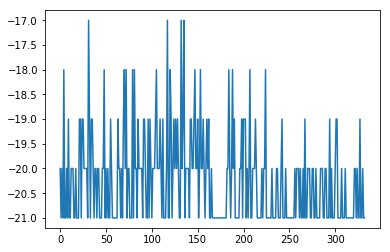

In [184]:
plt.plot(scores)

In [150]:
list(np.array(scores[2500:]) > 190).count(False)

6185

In [27]:
y = []
for i in range(1000):
    y.append(np.random.random() > 0.9)

In [29]:
y.count(False)

888

In [26]:
# loss = -m.log_prob(action) * reward
# loss.backward()

In [17]:
def cumulative_disc_rw(rewards,gamma):
    cumulative_rw = [sum(rewards[i:]) for i in range(len(rewards))]
    return cumulative_rw

In [18]:
data = []
net = Net(in_features,out_features)
n_episodes = 100
batch_size = 512
gamma = 0.9
optimizer = optim.Adam(params=net.parameters(),lr=0.0001)
for e in range(n_episodes):
#     print('-----------',e,'------------','\n','length of data',len(data))
    states = []
    actions = []
    rewards = []
    state = env.reset()
    done = False
    while not done:
        probs = net(torch.FloatTensor(state))
        m = Categorical(probs)
        action = m.sample().item()
#         action = env.action_space.sample()
        state,reward,done,_ = env.step(action)
        states.append(state)
        actions.append(action)
        rewards.append(reward)
        if done:
            break
#         env.render()
    env.close()
#     data.extend(list(zip(states,actions,rewards)))
    data.extend(list(zip(states,actions,cumulative_disc_rw(rewards,gamma))))
    
    if (len(data) > 1000) & (e % 3 == 0):
#         print('Training Network')
        
        batch = random.sample(data,k=batch_size)
        states_v = list(zip(*batch))[0]
        acts_v = list(zip(*batch))[1]
        rewards_v = list(zip(*batch))[2]
        rewards_v = np.array(rewards_v)
        rewards_v = rewards_v/(rewards_v.max()-rewards_v.min())
        acts_prob = net(torch.FloatTensor(states_v).view(batch_size,2))
        log_acts_v = torch.log(acts_prob)
        selected_log_prob = torch.FloatTensor(rewards_v) * log_acts_v[np.arange(len(acts_v)),acts_v]
        loss = -selected_log_prob.mean()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    if len(data) > 5000:
#         print("setting data to 5000")
        data = data[-5000:]
    if e % 100 == 0:
        print('-------------',e,'----------------')

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


------------- 0 ----------------


In [19]:
for e in range(50):
    state = env.reset()
    done = False
    while not done:
        probs = net(torch.FloatTensor(state))
        action = np.argmax(probs.detach().numpy())
#         action = env.action_space.sample()
        state,reward,done,_ = env.step(action)
        if done:
            break
        env.render()
    env.close()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
